In [ ]:
%pip install torch torchvision pytorch-lightning wandb matplotlib numpy scikit-learn --quiet

# Library Import

In [3]:
import os
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

from helper_functions import train_and_evaluate, save_model, save_history

# Data Loading


In [4]:
data_path = '100-bird-species'

### Data Augmentation

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.dataset = datasets.ImageFolder(root=self.data_path, transform=self.transform)
        self.classes = self.dataset.classes

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [12]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, fill=144),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

train_dataset = CustomDataset(f'{data_path}/train', transform)
test_dataset = CustomDataset(f'{data_path}/test', transform)
valid_dataset = CustomDataset(f'{data_path}/valid', transform)

In [13]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(84635, 2625, 2625)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
len(train_loader), len(test_loader)

(2645, 83)

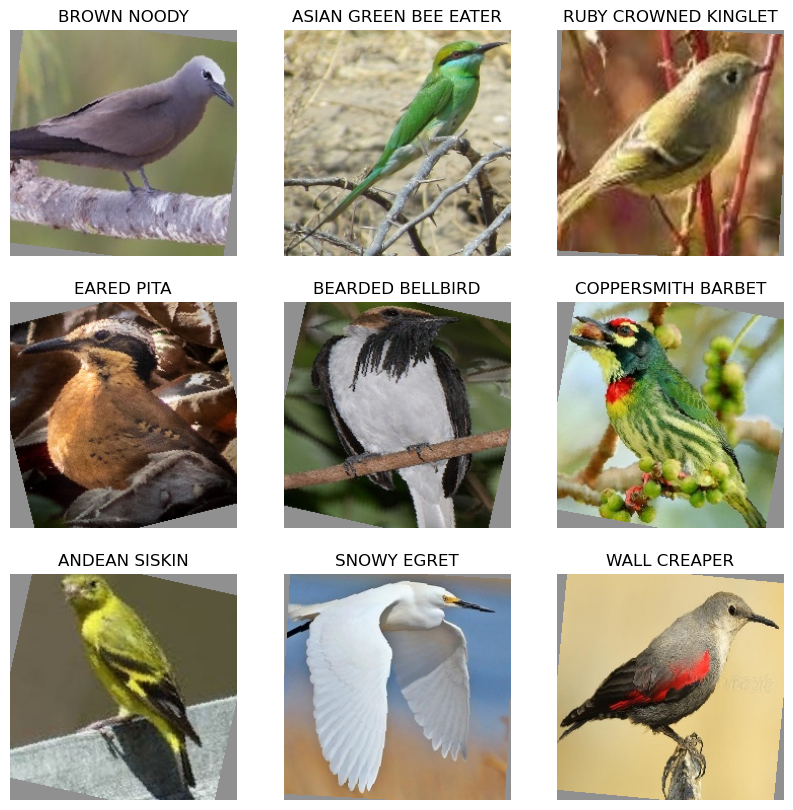

In [15]:
# Random plot some images in the training dataset
class_names = train_dataset.classes

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = np.random.randint(len(train_dataset))
        img, label = train_dataset[idx]
        ax[i, j].imshow(img.permute(1, 2, 0))
        ax[i, j].set_title(class_names[label])
        ax[i, j].axis('off')

# Model Building

### Hyperparameters

In [23]:
### HYPERPARAMETERS
# image
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
CLASSES = len(train_dataset.classes)
LABELS = train_dataset.classes

# training
SEED = 42
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
# mps only for apple devices with apple silicon, cuda for nvidia gpu, else cpu
DEVICE

'mps'

## Baseline

### Class and Instance

In [25]:
class Baseline(nn.Module):
    """ Model architecture that replicates the TinyVGG architecture """
    
    def __init__(self, 
                 input_features: int,
                 output_features: int,
                 hidden_units: int = 8):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_features, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 56 * 56,
                      out_features=output_features),
        )
        
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [26]:
# create a model instance
torch.manual_seed(SEED)
baseline = Baseline(input_features=CHANNELS, output_features=CLASSES)
baseline.to(DEVICE)

Baseline(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=25088, out_features=525, bias=True)
  )
)

### Functions

In [27]:
# define the loss function and the optimizer
# modify based on your task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=CLASSES).to(DEVICE)

# writer to tensorboard
# !!!! remember change the writer name to <model_name>_<version>, dont't overwrite the previous model
writer = SummaryWriter('runs/baseline_v1')

### Training

In [28]:
# train the model
history = train_and_evaluate(model=baseline, 
                   train_loader=train_loader, 
                   test_loader=test_loader, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   scheduler=scheduler, 
                   accuracy_fn=accuracy_fn, 
                   writer=writer, 
                   device=DEVICE, 
                   start_epoch=1,
                   end_epoch=10)

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 1 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 2 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 2 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 3 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 3 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 4 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 4 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 5 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 5 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 6 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 6 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 7 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 7 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 8 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 8 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 9 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 9 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

Epoch 10 | Training:   0%|          | 0/265 [00:00<?, ?batch/s]

Epoch 10 | Evaluating:   0%|          | 0/9 [00:00<?, ?batch/s]

### Save Model and History

In [29]:
# save the model
save_model(baseline, 'baseline_v1')

PosixPath('models/baseline_v1.pth')

In [64]:
# Create DataFrames for train and eval data
train_df = pd.DataFrame(history['train'])
eval_df = pd.DataFrame(history['eval'])

# Add a column to distinguish between train and eval data
train_df['set'] = 'train'
eval_df['set'] = 'eval'

# Combine the two DataFrames
history_df = pd.concat([train_df, eval_df], ignore_index=True)
history_df

,epoch,loss,accuracy,set
0,1,4.479403,0.017689,train
1,2,3.918435,0.070786,train
2,3,3.169101,0.207461,train
3,4,5.082155,0.049646,train
4,5,4.058276,0.019811,train
5,6,4.033159,0.018396,train
6,7,4.039144,0.021108,train
7,8,4.119860,0.021242,train
8,9,10.687960,0.017099,train
9,10,4.366089,0.020653,train


In [65]:
# save the history to a csv file
save_history(history_df, 'baseline_v1')

### Load Model

In [66]:
# load the model
baseline_trained = Baseline(input_features=CHANNELS, output_features=CLASSES)
baseline_trained.load_state_dict(torch.load('models/baseline_v1.pth'))

/var/folders/md/rch60bjd0sz1jyk0vg1yh33c0000gn/T/ipykernel_62225/716877924.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_trained.load_state_dict(torch.load('m

<All keys matched successfully>

## MobileNet

### MobileNet Class

In [84]:
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),

            # 5 Depthwise Separable Conv layers with stride 1
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),
            DepthwiseSeparableConv(512, 512, stride=1),

            DepthwiseSeparableConv(512, 1024, stride=2),
            DepthwiseSeparableConv(1024, 1024, stride=1),

            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

In [85]:
# create a model instance
torch.manual_seed(SEED)
mobilenet = MobileNet(num_classes=CLASSES)
mobilenet.to(DEVICE)

MobileNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (4): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): DepthwiseSeparableConv(
      (depthwise): Con

### Functions

In [ ]:
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.01)
accuracy_fn = Accuracy(task="multiclass", num_classes=CLASSES).to(DEVICE)

# !!!! remember change the writer name to <model_name>_<version>
writer = SummaryWriter('runs/mobilenet_v1')

### Training

In [ ]:
history = train_and_evaluate(model=mobilenet, 
                   train_loader=train_loader, 
                   test_loader=test_loader, 
                   criterion=criterion, 
                   optimizer=optimizer, 
                   scheduler=scheduler, 
                   accuracy_fn=accuracy_fn, 
                   writer=writer, 
                   device=DEVICE, 
                   start_epoch=1,
                   end_epoch=10)

## EfficientNet

### Class and Instance

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, stride):
        super(MBConv, self).__init__()
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU()
        ) if expand_ratio != 1 else nn.Identity()
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU()
        )
        
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        residual = x
        x = self.expand(x)
        x = self.depthwise(x)
        x = self.project(x)
        if self.use_residual:
            x += residual
        return x

class EfficientNetV2(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetV2, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.SiLU()
        )
        
        self.mbconv_layers = nn.Sequential(
            MBConv(32, 16, 1, 1),
            MBConv(16, 32, 4, 2),
            MBConv(32, 32, 4, 1),
            MBConv(32, 64, 4, 2),
            MBConv(64, 64, 4, 1),
            MBConv(64, 128, 6, 2),
            MBConv(128, 128, 6, 1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.SiLU()
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mbconv_layers(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [13]:
# create a model instance
torch.manual_seed(SEED)
effnet = EfficientNetV2(num_classes=CLASSES)
effnet = effnet.to(DEVICE)

OrderedDict([('conv1.0.weight',
              tensor([[[[ 0.1471,  0.1597, -0.0451],
                        [ 0.1768, -0.0422,  0.0388],
                        [-0.0937,  0.1130,  0.1697]],
              
                       [[-0.1412,  0.1673,  0.0360],
                        [ 0.1422,  0.0261,  0.0928],
                        [-0.0272,  0.1484,  0.0284]],
              
                       [[-0.0898,  0.0491, -0.0887],
                        [-0.0226, -0.0782,  0.1277],
                        [-0.1519, -0.0887, -0.0543]]],
              
              
                      [[[-0.1157,  0.0182, -0.1901],
                        [ 0.1738, -0.1635,  0.1486],
                        [ 0.0320, -0.0625,  0.1189]],
              
                       [[ 0.0300,  0.1555,  0.0210],
                        [-0.0607,  0.0517, -0.0522],
                        [ 0.0810,  0.1718,  0.1112]],
              
                       [[-0.0841,  0.1111,  0.0344],
                        

### Functions

In [14]:
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
accuracy_fn = Accuracy(task="multiclass", num_classes=CLASSES).to(DEVICE)

# !!!! remember change the writer name to <model_name>_<version>
writer = SummaryWriter('runs/effnet_v1')

### Training

In [16]:
EPOCHS = 10

history = {}
torch.manual_seed(SEED)
effnet = effnet.to(DEVICE)
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epoch", leave=True):
    train_result = train_model(model=effnet,
                               data_loader=train_loader,
                               loss_fn=criterion,
                               optimizer=optimizer,
                               accuracy_fn=accuracy_fn,
                               device=DEVICE,
                               epoch=epoch,
                               writer=writer)
    
    eval_result = eval_model(model=effnet,
                             data_loader=test_loader,
                             loss_fn=criterion,
                             accuracy_fn=accuracy_fn,
                             device=DEVICE,
                             epoch=epoch)
    
    history[epoch] = {'train': train_result, 'eval': eval_result}
    print()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 1 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 2 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 2 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 3 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 3 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 4 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 4 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 5 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 5 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 6 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 6 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 7 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 7 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 8 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 8 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 9 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 9 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 10 | Training:   0%|          | 0/2645 [00:00<?, ?it/s]

Epoch 10 | Evaluating:   0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
# Train more 5 epochs
EPOCHS = 5

history = {}
torch.manual_seed(SEED)
effnet = effnet.to(DEVICE)
for epoch in tqdm(range(1, EPOCHS + 1), desc="Epoch", leave=True):
    train_result = train_model(model=effnet,
                               data_loader=train_loader,
                               loss_fn=criterion,
                               optimizer=optimizer,
                               accuracy_fn=accuracy_fn,
                               device=DEVICE,
                               epoch=epoch,
                               writer=writer)
    
    eval_result = eval_model(model=effnet,
                             data_loader=test_loader,
                             loss_fn=criterion,
                             accuracy_fn=accuracy_fn,
                             device=DEVICE,
                             epoch=epoch)
    
    history[epoch] = {'train': train_result, 'eval': eval_result}
    print()

In [17]:
# Save the model and history
MODEL_NAME = 'effnet_v1'
save_model(effnet, MODEL_NAME)

PosixPath('models/effnetv1.pth.pth')

In [18]:
import pandas as pd

# Flatten the nested dictionary structure and calculate progress
data = []

for epoch, epoch_data in history.items():
    for result_type, result in epoch_data.items():
        for i, result_entry in enumerate(result['result'], start=1):
            progress = (epoch - 1) + (i/ len(result['result']))
            data.append({
                'epoch': epoch,
                'batch': result_entry['batch'],
                'progress': progress,
                'type': result_type.capitalize(),
                'loss': result_entry['loss'],
                'accuracy': result_entry['accuracy']   
            })

# Create a DataFrame from the flattened data
df = pd.DataFrame(data)

# Display the DataFrame
df

,epoch,batch,progress,type,loss,accuracy
0,1,1,0.000378,Train,6.277685,0.0
1,1,2,0.000756,Train,7.170446,0.0
2,1,3,0.001134,Train,7.623193,0.0
3,1,4,0.001512,Train,7.543108,0.0
4,1,5,0.001890,Train,7.492291,0.0
...,...,...,...,...,...,...
27275,10,79,9.951807,Eval,"tensor(0.4935, device='mps:0')","tensor(0.8699, device='mps:0')"
27276,10,80,9.963855,Eval,"tensor(0.5071, device='mps:0')","tensor(0.8672, device='mps:0')"
27277,10,81,9.975904,Eval,"tensor(0.5052, device='mps:0')","tensor(0.8677, device='mps:0')"
27278,10,82,9.987952,Eval,"tensor(0.5053, device='mps:0')","tensor(0.8678, device='mps:0')"


In [20]:
# Save history dataframe into csv
PATH = Path("historys")
PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "effnetv1"

FILE_EXT = ".csv"
HISTORY_SAVE_PATH = PATH / f"{MODEL_NAME}{FILE_EXT}"

# Save history dataframe
df.to_csv(HISTORY_SAVE_PATH, index=False)

save_history